# 1: Imports & Installs

In [1]:
!pip install py_dempster_shafer

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyds import MassFunction

In [3]:
# The path for the csv files needs to be changed if used locally
csv1 = 'https://raw.githubusercontent.com/Jesus-Cries/Evidenztheorie/main/resources/DPE21_1.csv'
csv2 = 'https://raw.githubusercontent.com/Jesus-Cries/Evidenztheorie/main/resources/DPE21_2.csv'

df = pd.read_csv(csv1, sep=";")
df2 = pd.read_csv(csv2, sep=";")

dfs = [df, df2]

# 2: Data Exploration

In [4]:
# pd.concat([df,df2],axis=1).head(5)

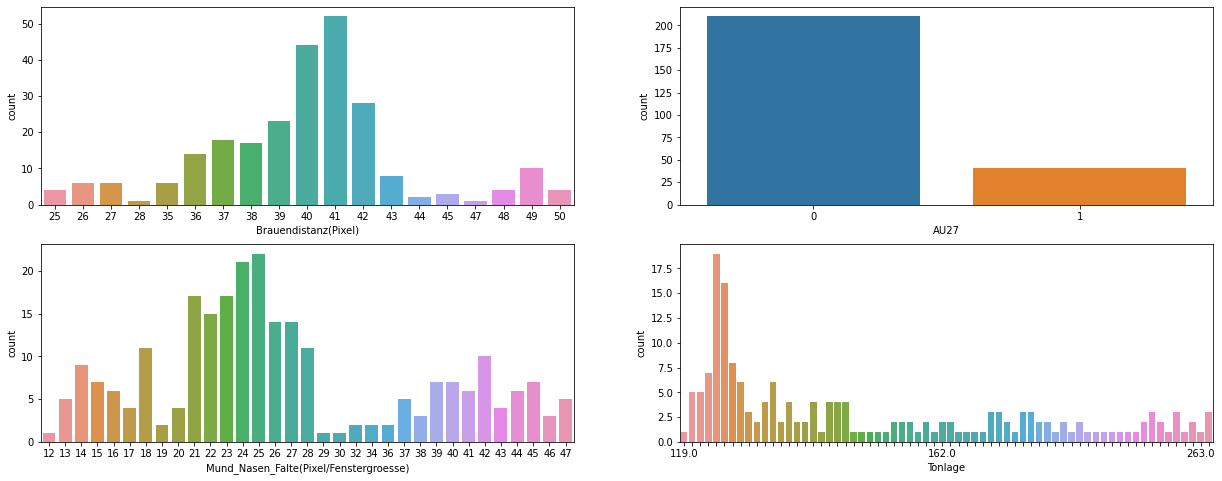

In [5]:
def histogram(data):
  fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(21,8))

  sns.countplot(ax=axes[0][0], data=data, x="Brauendistanz(Pixel)")
  sns.countplot(ax=axes[0][1], data=data, x="AU27")
  sns.countplot(ax=axes[1][0], data=data, x="Mund_Nasen_Falte(Pixel/Fenstergroesse)")
  a = sns.countplot(ax=axes[1][1], data=data, x="Tonlage")

  for ind, label in enumerate(a.get_xticklabels()):
      if ind % 32 == 0: 
        label.set_visible(True)
      else:
        label.set_visible(False)

histogram(df)

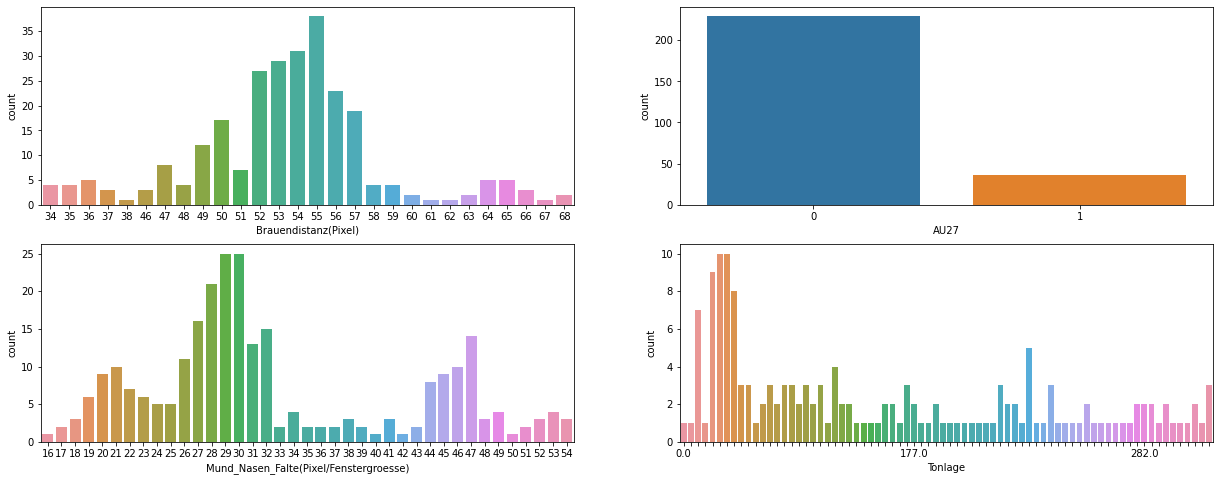

In [6]:
histogram(df2)

In [7]:
# for dataframe in dfs:
#   dataframe.hist(figsize=(15, 5), xrot=-45)
#   plt.show()

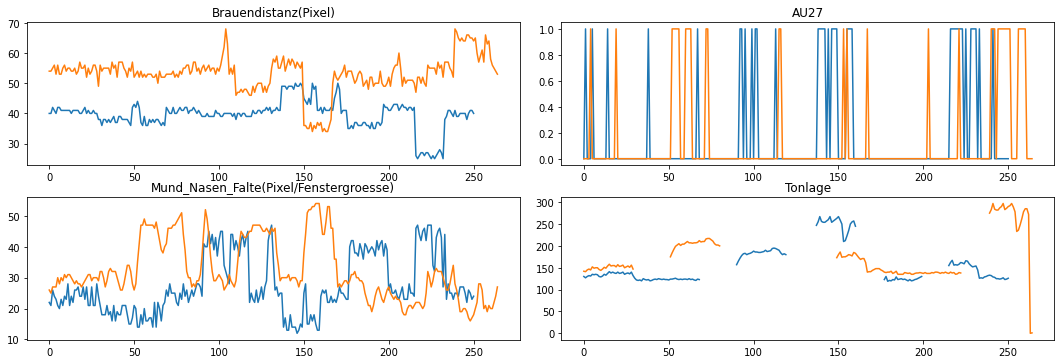

In [8]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.tight_layout()

for i, column in enumerate(df.columns):
  if column is not "t":
    row = 0
    if i > 2:
      row = 1
    
    for dataframe in dfs:
      dataframe[[column]].plot(ax=axes[row][(i-1)%2], legend=False, title=column)

In [9]:
display(df.select_dtypes(exclude=["object"]).isnull().sum())
print("-"*100)
display(df2.select_dtypes(exclude=["object"]).isnull().sum())

Brauendistanz(Pixel)                       0
AU27                                       0
Mund_Nasen_Falte(Pixel/Fenstergroesse)     0
Tonlage                                   69
dtype: int64

----------------------------------------------------------------------------------------------------


Brauendistanz(Pixel)                        0
AU27                                        0
Mund_Nasen_Falte(Pixel/Fenstergroesse)      0
Tonlage                                   105
dtype: int64

## 2.1: Erkenntnisse
1. Bei AU27 handelt es sich um boolsche Werte
2. Alles andere sind numerische Werte
3. Informationen zur Tonlage fehlen teilweise
4. Im zeitlichen Verlauf der numerischen Daten sind eindeutige Intervalle zu erkennen

# 3: Features
- Brauendistanz
  - Groß: Überraschung / Angst
  - Besonders Klein: Wut
- AU27
  - Angst / Überraschung
- Mund- / Wangenfalte
  - Groß: Freude
  - Klein: Angst
- Tonlage
  - Hoch: Angst
  - Tief: Traurigkeit / Ekel

|              | Brauendistanz   | AU27 | Mund / Wangenfalte | Tonlage |
|:------------:|:---------------:|:----:|:----------------:|:-------:|
| Angst        | groß            | 1    | klein            | hoch    |
| Überraschung | groß            | 1    | normal           | normal  |
| Wut          | besonders klein | 0    | normal           | normal  |
| Freude       | normal          | 0    | groß             | normal  |
| Ekel         | normal          | 0    | normal           | tief    |
| Traurigkeit  | normal          | 0    | normal           | tief    |



# 4: Verknüpfung von Features - Prototype

In [10]:
# "Ich glaube, die Brauendistanz war groß"
m1 = MassFunction({"au": 0.8, "fet": 0.15, "w":0.05})
print("m1:", m1)

# "Ich glaube, AU27 wurde erkannt"
m2 = MassFunction({"au": 1, "wfet": 0})

m12 = m1 & m2
print("m12:", m12)

# "Ich glaube die Mund / Wangenfalte könnte klein gewesen sein"
m3 = MassFunction({"uwet": 0.2, "a": 0.6, "f":0.2})
m123 = m12 & m3
print("m123:", m123)

# "Ich glaube die Tonlage war sehr hoch"
m4 = MassFunction({"a": 0.75, "uwf": 0.2, "et": 0.05})
m1234 = m123 & m4
print("m1234:", m1234)

print("\nfrom_q:", m1234.from_q(m12))
print("max bel:",m1234.max_bel())
print("max pl:",m1234.max_pl())

print("\na bel:" , m1234.bel("a"))
print("a pl:" , m1234.pl("a"))

print("\nEs ist Angst:", m1234.pl("a"))
print("Es ist etwas anderes:", m1234.pl("uwfet"))

m1: {{'u', 'a'}:0.8; {'e', 'f', 't'}:0.15; {'w'}:0.05}
m12: {{'u', 'a'}:1.0; {'e', 'f', 't'}:0.0; {'w'}:0.0}
m123: {{'a'}:0.7499999999999999; {'u'}:0.25; {'e', 't'}:0.0; {'f'}:0.0; {'w'}:0.0}
m1234: {{'a'}:0.9183673469387754; {'u'}:0.0816326530612245; {'e', 't'}:0.0; {'f'}:0.0; {'w'}:0.0}

from_q: {{'u', 'a'}:1.0}
max bel: frozenset({'a'})
max pl: frozenset({'a'})

a bel: 0.9183673469387754
a pl: 0.9183673469387754

Es ist Angst: 0.9183673469387754
Es ist etwas anderes: 0.0816326530612245


# 5: Calculation of Probability

In [11]:
for column in df.columns:
  if column not in ["t", "AU27"]:
    print("\n" + column)
    print("Max:  ", df[column].max())
    print("Mean: ", df[column].mean())
    print("Min:  ", df[column].min())


Brauendistanz(Pixel)
Max:   50
Mean:  39.57370517928287
Min:   25

Mund_Nasen_Falte(Pixel/Fenstergroesse)
Max:   47
Mean:  27.390438247011954
Min:   12

Tonlage
Max:   267.0
Mean:  155.82417582417582
Min:   119.0


In [12]:
def getProbabilites(columnName, index, debug=False, dfNumber=1): 
  """
  This function takes the value in column columnName and index index.
  It then calculates the probability at which it would classify this value
  into three categories:
  1: High (pMax)
  2: Normal (pMean)
  3: Low (pMin)
  Debugging can be activated by setting debug to True.
  The dataframe can be changed by setting dfNumber to either 1 or 2.
  Returns: pMin, pMean, pMax
  """

  if dfNumber == 1:
    currentDf = df[columnName]
  elif dfNumber == 2:
    currentDf = df2[columnName]

  currentValue = currentDf[index]
  if pd.isna(currentValue):
    return -1, -1, -1

  if columnName != "AU27":
    currentValueAveraged = 0
    for i in [[-2, 0.05], [-1, 0.20], [0, 0.50], [1, 0.20], [2, 0.05]]:

      newIndex = index + i[0]
      # Check if index is in range of dataframe
      if newIndex < 0 or newIndex >= len(currentDf):
        if debug:
          print("Index", newIndex, "not in range: ", end="")
        value = currentValue
      else:
        if debug:
          print("Index", newIndex, "in range: ", end="")
        value = currentDf[newIndex]

      if debug:
        print(i[1], ": ", value)

      # Check if value is NaN
      if pd.isna(value):
        value = currentValue
      
      currentValueAveraged += value * i[1]

    if debug:
      print(currentValue, "-->", currentValueAveraged)

    currentValue = currentValueAveraged

  max = currentDf.max()
  mean = currentDf.mean()
  min = currentDf.min()

  distToMax = abs(currentValue - max)
  distToMean = abs(currentValue - mean)
  distToMin = abs(currentValue - min)

  if debug:
    print("\nCurrent value:", currentValue, "\n")
    debugInformation = pd.DataFrame(columns=["Description", "Low", "Normal", "High"])
    debugInformation = debugInformation.append({"Description": "Boundary", "Low": min, "Normal": mean, "High": max}, ignore_index=True)
    debugInformation = debugInformation.append({"Description": "Distance", "Low": distToMin, "Normal": distToMean, "High": distToMax}, ignore_index=True)
  
  if distToMax == 0:
    pMax = 1 - 1e-15 -1e-15
    pMean = 1e-15
    pMin = 1e-15
  elif distToMean == 0:
    pMax = 1e-15
    pMean = 1 - 1e-15 -1e-15
    pMin = 1e-15
  elif distToMin == 0:
    pMax = 1e-15
    pMean = 1e-15
    pMin = 1 - 1e-15 -1e-15
  else:
    distToMax = 1 / (distToMax ** 2)
    distToMean = 1 / (distToMean ** 2)
    distToMin = 1 / (distToMin ** 2)

    totalDistance = distToMax + distToMean + distToMin

    pMax = distToMax / totalDistance
    pMean = distToMean / totalDistance
    pMin = distToMin / totalDistance

  if debug:
    debugInformation = debugInformation.append({"Description": "Probability", "Low": pMin, "Normal": pMean, "High": pMax}, ignore_index=True)
    display(debugInformation)
    print()

  return pMin, pMean, pMax

In [13]:
dfNumber = 1

In [14]:
min, mean, max = getProbabilites("Brauendistanz(Pixel)", 144, True, dfNumber)

Index 142 in range: 0.05 :  49
Index 143 in range: 0.2 :  49
Index 144 in range: 0.5 :  48
Index 145 in range: 0.2 :  50
Index 146 in range: 0.05 :  49
48 --> 48.7

Current value: 48.7 



,Description,Low,Normal,High
0,Boundary,25,39.573705,50
1,Distance,23.7,9.126295,1.3
2,Probability,0.00294027,0.019829,0.977231


In [15]:
min, mean, max = getProbabilites("Mund_Nasen_Falte(Pixel/Fenstergroesse)", 12, True, dfNumber)

Index 10 in range: 0.05 :  23
Index 11 in range: 0.2 :  28
Index 12 in range: 0.5 :  21
Index 13 in range: 0.2 :  24
Index 14 in range: 0.05 :  22
21 --> 23.150000000000002

Current value: 23.150000000000002 



,Description,Low,Normal,High
0,Boundary,12,27.390438,47
1,Distance,11.15,4.240438,23.85
2,Probability,0.122963,0.850162,0.0268749


In [16]:
min, mean, max = getProbabilites("Tonlage", 37, True, dfNumber)

Index 35 in range: 0.05 :  125.0
Index 36 in range: 0.2 :  123.0
Index 37 in range: 0.5 :  122.0
Index 38 in range: 0.2 :  123.0
Index 39 in range: 0.05 :  120.0
122.0 --> 122.44999999999999

Current value: 122.44999999999999 



,Description,Low,Normal,High
0,Boundary,119.00000,155.824176,267.000000
1,Distance,3.45000,33.374176,144.550000
2,Probability,0.98887,0.010567,0.000563


In [17]:
# INFO: Für AU27 müssen keine Wahrscheinlichkeiten berechnet werden, weil nur die Werte 0 und 1 angenommen werden können,
# für die bereits ein anderer Klassifikator verantwortlich ist
min, mean, max = getProbabilites("AU27",1, True, dfNumber)


Current value: 1 



,Description,Low,Normal,High
0,Boundary,0,1.633466e-01,1
1,Distance,1,8.366534e-01,0
2,Probability,1e-15,1.000000e-15,1


# 6: Berechnung

Die Funktion getMassFunctions bekommt eine Liste mit drei bis vier Objekten, welche aus der Funktion getConjunctions entstehen und berechnet dann die Massfunction für einen Eintrag

In [18]:
def getMassFunctions(arrMassFunctions):
  m = []
  length = len(arrMassFunctions)
  for i in range(0, length):
    mf = MassFunction(arrMassFunctions[i])
    m.append(mf)

  m12 = m[0] & m[1]
  resultMassFunction = m12 & m[2]
  if length == 4:
    resultMassFunction = resultMassFunction & m[3]

  return resultMassFunction

In [19]:
def getConjunctions(columnname, low, medium, high):
  if(columnname == "Brauendistanz(Pixel)"):
    return {"au":high, "w":low, "fet":medium}
  if(columnname == "AU27"):
    return {"au": high, "wfet": low}
  if(columnname == "Mund_Nasen_Falte(Pixel/Fenstergroesse)"):
    return {"a": low, "uwet": medium, "f":high}
  if(columnname == "Tonlage"):
    return {"a": high, "uwf": medium, "et": low}

In [20]:
def identifyEmotions(dataframe, which, debug=False):
  # Transpose dataframe for reduced complexity
  dataframe = dataframe.T
  results = []

  for row in dataframe.columns:
    conjunctions = []

    for i in range(0, dataframe.shape[0]):
      if dataframe.index[i] not in ["t"]:
        if(dataframe.index[i] == "AU27"):
          medium = 0
          if(dataframe.at["AU27",row] == 1):
            high = 1- 1e-15
            low = 1e-15
          else:
            high = 1e-15
            low = 1 - 1e-15

        else:
          low, medium, high = getProbabilites(dataframe.index[i], row, False, which)
          
        if(low != -1):
          conjunction = getConjunctions(dataframe.index[i], low, medium, high)
          conjunctions.append(conjunction)

          if debug:
            print(conjunctions[-1])

    result = getMassFunctions(conjunctions)

    print(row, end="")
    print(":")
    print(result)

    results.append(result)

  return results

# 7: Testing


## 7.1: Angst

In [21]:
# Brauendistanz [25 - 30], [35 - 44] , [45-50]
# Mund_Nasen_Falte [12 - 17] , [22 - 35] , [39 - 47] 
# Tonlage [119 - 133] , [140 - 208] , [215-267] 

ifBrauenA = df["Brauendistanz(Pixel)"] > 45
ifAU27A = df["AU27"] == 1
ifFalteA = df["Mund_Nasen_Falte(Pixel/Fenstergroesse)"]  < 17
ifTonA = df["Tonlage"] > 215

# Zeitpunkte, die eindeutig als Angst zu erkennen sind
df[ifBrauenA & ifAU27A & ifFalteA & ifTonA].head(3)

,t,Brauendistanz(Pixel),AU27,Mund_Nasen_Falte(Pixel/Fenstergroesse),Tonlage
138,"13,8",49,1,14,255.0
140,14,48,1,13,256.0
141,"14,1",49,1,13,254.0


In [22]:
# Hiermit wird die Vermutung bestätigt => zu 99% Angst
identifyEmotions(df[df["t"] == "13,8"],1, False)

138:
{{'a'}:0.9965835830500422; {'u'}:0.003416416949957793; {'e', 't'}:4.7626353297780966e-20; {'w'}:1.2951648500117149e-20; {'f'}:1.029010520424236e-20}


[{frozenset({'a'}): 0.9965835830500422,
  frozenset({'u'}): 0.003416416949957793,
  frozenset({'w'}): 1.2951648500117149e-20,
  frozenset({'e', 't'}): 4.7626353297780966e-20,
  frozenset({'f'}): 1.029010520424236e-20}]

## 7.2: Überraschung

In [23]:
# Brauendistanz [25 - 30], [35 - 44] , [45-50]
# Mund_Nasen_Falte [12 - 17] , [22 - 35] , [39 - 47] 
# Tonlage [119 - 133] , [140 - 208] , [215-267] 

ifBrauenUb = df["Brauendistanz(Pixel)"] > 45
ifAU27Ub = df["AU27"] == 1
ifFalteUb1 = df["Mund_Nasen_Falte(Pixel/Fenstergroesse)"] > 22 
ifFalteUb2 =   df["Mund_Nasen_Falte(Pixel/Fenstergroesse)"] < 35
ifTonUb1 = df["Tonlage"] > 140
ifTonUb2 = df["Tonlage"] < 208

# Zeitpunkte, die eindeutig als Überraschung zu erkennen sind
df[ifBrauenUb & ifAU27Ub & ifFalteUb1 & ifFalteUb2 & ifTonUb1 & ifTonUb2]

# Mit einer Einteilung in harte Grenzen, gibt es kein gefundenen Fall der Überraschung
# trotzdem wird Überraschung gefunden, wenn die Parameter nah an den Grenzen liegen

,t,Brauendistanz(Pixel),AU27,Mund_Nasen_Falte(Pixel/Fenstergroesse),Tonlage


In [24]:
# Ein Fall, in welchem Überraschung gefunden wird
display(df[df["t"] == "24,1"])
print("\n")
# => zu 99% Überraschung
display(identifyEmotions(df[df["t"] == "24,1"],1, False))

,t,Brauendistanz(Pixel),AU27,Mund_Nasen_Falte(Pixel/Fenstergroesse),Tonlage
241,"24,1",39,1,24,129.0




241:
{{'u'}:0.9987546449003711; {'a'}:0.0012453550849885586; {'e', 't'}:1.461309379070635e-11; {'f'}:2.6724872723768873e-14; {'w'}:5.501159354184823e-16}


[{frozenset({'a'}): 0.0012453550849885586,
  frozenset({'u'}): 0.9987546449003711,
  frozenset({'w'}): 5.501159354184823e-16,
  frozenset({'e', 't'}): 1.461309379070635e-11,
  frozenset({'f'}): 2.6724872723768873e-14}]

## 7.3: Wut

In [25]:
# Brauendistanz [25 - 30] = low, [35 - 44] = medium, [45-50] = high
# Mund_Nasen_Falte [12 - 17] = low, [22 - 35] = medium, [39 - 47] = high 
# Tonlage [119 - 133] = low, [140 - 208] = medium, [215-267] = high 

ifBrauenW = df["Brauendistanz(Pixel)"] < 30
ifAU27W = df["AU27"] == 0
ifFalteW1 = df["Mund_Nasen_Falte(Pixel/Fenstergroesse)"] > 22 
ifFalteW2 =   df["Mund_Nasen_Falte(Pixel/Fenstergroesse)"] < 35
ifTonW1 = df["Tonlage"] > 140
ifTonW2 = df["Tonlage"] < 208

# Zeitpunkte, die eindeutig als Wut zu erkennen sind
df[ifBrauenW & ifAU27W & ifFalteW1 & ifFalteW2 & ifTonW1 & ifTonW2] 

,t,Brauendistanz(Pixel),AU27,Mund_Nasen_Falte(Pixel/Fenstergroesse),Tonlage
226,"22,6",26,0,34,165.0
227,"22,7",25,0,32,159.0
232,"23,2",25,0,27,145.0


In [26]:
# Ein Fall, in welchem Wut gefunden wird
# => zu 99% Wut
identifyEmotions(df[df["t"] == "22,6"],1, False)

226:
{{'w'}:0.9980283790362499; {'f'}:0.0019203821801151836; {'e', 't'}:5.123878363499702e-05; {'u'}:6.034839701240458e-19; {'a'}:4.674767296349737e-22}


[{frozenset({'a'}): 4.674767296349737e-22,
  frozenset({'u'}): 6.034839701240458e-19,
  frozenset({'w'}): 0.9980283790362499,
  frozenset({'e', 't'}): 5.123878363499702e-05,
  frozenset({'f'}): 0.0019203821801151836}]

## 7.4: Freude

In [27]:
# Brauendistanz [25 - 30] = low, [35 - 44] = medium, [45-50] = high
# Mund_Nasen_Falte [12 - 17] = low, [22 - 35] = medium, [39 - 47] = high 
# Tonlage [119 - 133] = low, [140 - 208] = medium, [215-267] = high 

ifBrauenF1 = df["Brauendistanz(Pixel)"] > 35
ifBrauenF2 = df["Brauendistanz(Pixel)"] < 44
ifAU27F = df["AU27"] == 0
ifFalteF = df["Mund_Nasen_Falte(Pixel/Fenstergroesse)"] > 39
ifTonF1 = df["Tonlage"] > 140
ifTonF2 = df["Tonlage"] < 208

# Zeitpunkte, die eindeutig als Freude zu erkennen sind
df[ifBrauenF1 & ifBrauenF2 & ifAU27F & ifFalteF & ifTonF1 & ifTonF2].head(3)

,t,Brauendistanz(Pixel),AU27,Mund_Nasen_Falte(Pixel/Fenstergroesse),Tonlage
91,"9,1",39,0,41,165.0
94,"9,4",39,0,45,182.0
96,"9,6",39,0,44,180.0


In [28]:
# Hiermit wird die Vermutung bestätigt => zu 94% Freude
identifyEmotions(df[df["t"] == "9,1"],1)

91:
{{'f'}:0.9478093919269026; {'e', 't'}:0.05085401599234026; {'w'}:0.001336592080757225; {'u'}:2.2365783315827306e-18; {'a'}:2.8356140817279984e-21}


[{frozenset({'a'}): 2.8356140817279984e-21,
  frozenset({'u'}): 2.2365783315827306e-18,
  frozenset({'w'}): 0.001336592080757225,
  frozenset({'e', 't'}): 0.05085401599234026,
  frozenset({'f'}): 0.9478093919269026}]

## 7.5: Ekel, Traurigkeit

In [29]:
# Brauendistanz [25 - 30] = low, [35 - 44] = medium, [45-50] = high
# Mund_Nasen_Falte [12 - 17] = low, [22 - 35] = medium, [39 - 47] = high 
# Tonlage [119 - 133] = low, [140 - 208] = medium, [215-267] = high 

ifBrauenET1 = df["Brauendistanz(Pixel)"] > 35
ifBrauenET2 = df["Brauendistanz(Pixel)"] < 44
ifAU27ET = df["AU27"] == 0
ifFalteET1 = df["Mund_Nasen_Falte(Pixel/Fenstergroesse)"] > 22 
ifFalteET2 =   df["Mund_Nasen_Falte(Pixel/Fenstergroesse)"] < 35
ifTonET = df["Tonlage"] > 215


# Zeitpunkte, die eindeutig als Ekel oder Traurigkeit zu erkennen sind
df[ifBrauenET1 & ifBrauenET2 & ifAU27ET & ifFalteET1 & ifFalteET2 & ifTonET].head(3)

,t,Brauendistanz(Pixel),AU27,Mund_Nasen_Falte(Pixel/Fenstergroesse),Tonlage
160,16,42,0,24,245.0


In [30]:
# Ein Fall, in welchem Ekel oder Traurigkeit gefunden wird
# => zu 89% Ekel oder Traurigkeit
identifyEmotions(df[df["t"] == "16"],1, False)

160:
{{'e', 't'}:0.8910468400247176; {'f'}:0.08834165401746044; {'w'}:0.02061150595782138; {'a'}:5.889595652785701e-16; {'u'}:7.363987171518881e-17}


[{frozenset({'a'}): 5.889595652785701e-16,
  frozenset({'u'}): 7.363987171518881e-17,
  frozenset({'w'}): 0.02061150595782138,
  frozenset({'e', 't'}): 0.8910468400247176,
  frozenset({'f'}): 0.08834165401746044}]

# 8: Exporting the results

In [31]:
# Exports and prints out results for both dataframes
for dfNumber in [1, 2]:

  print("\n\n" + str(dfNumber) + ". file\n")

  if dfNumber == 1:
    currentDf = pd.read_csv(csv1, sep=";")
  elif dfNumber == 2:
    currentDf = pd.read_csv(csv2, sep=";")

  results = identifyEmotions(currentDf, dfNumber, False)

  emotionResults = []
  for i, row in enumerate(results):
    x, = row.max_pl()
    if x == "e" or x == "t":
      x = "et"
    emotionResults.append(x)

  currentDf["Emotion"] = emotionResults
  filename = "DPE21_" + str(dfNumber) + "_emotions.csv"
  currentDf.to_csv(filename, sep=";")
  print("\n")



1. file

0:
{{'e', 't'}:0.9926643829313198; {'f'}:0.0071488198029354124; {'w'}:0.00018679726574474567; {'u'}:4.345642746909452e-19; {'a'}:4.6565921710552725e-21}
1:
{{'u'}:0.9908267618212011; {'a'}:0.009173238177806207; {'e', 't'}:9.874667238501266e-13; {'f'}:4.920471618932899e-15; {'w'}:3.785711408342951e-16}
2:
{{'e', 't'}:0.9949421878593258; {'f'}:0.0033081979222902304; {'w'}:0.0017496142183839765; {'u'}:5.929348598562654e-18; {'a'}:1.3976783912031618e-20}
3:
{{'e', 't'}:0.9923172947652864; {'f'}:0.00569912128153283; {'w'}:0.0019835839531807133; {'u'}:6.269104839682261e-18; {'a'}:1.7615731191140473e-20}
4:
{{'e', 't'}:0.9873544772575469; {'f'}:0.01083205833041655; {'w'}:0.001813464412036501; {'u'}:5.34869158578442e-18; {'a'}:2.988592574150885e-20}
5:
{{'u'}:0.989352024341369; {'a'}:0.010647975658587543; {'e', 't'}:4.2180863616086817e-14; {'f'}:1.041353896818676e-15; {'w'}:2.6255531224486313e-16}
6:
{{'e', 't'}:0.9634332512841789; {'f'}:0.029080875688395017; {'w'}:0.007485873027426